In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display
%matplotlib inline

In [3]:
df = pd.read_csv('CreditScoring.csv')
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [4]:
df.columns = df.columns.str.lower()
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [6]:
print(df.status.value_counts())

status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)
df.head()

status
1    3200
2    1254
0       1
Name: count, dtype: int64


,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,1,60,30,2,1,3,73,129,0,0,800,846
1,ok,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,default,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,ok,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,ok,0,1,36,26,1,1,1,46,107,0,0,310,910


In [7]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}
df.home = df.home.map(home_values)
 
marital_values = {
    1: 'single', 
    2: 'married', 
    3: 'widow', 
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}
df.marital = df.marital.map(marital_values)
 
records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}
df.records = df.records.map(records_values)
 
job_values = {
    1: 'fixed', 
    2: 'partime', 
    3: 'freelance', 
    4: 'others',
    0: 'unk'
}
df.job = df.job.map(job_values)
 
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [8]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [9]:
for col in ['income', 'assets', 'debt']:
    df[col] = df[col].replace(to_replace=99999999, value=np.nan)

df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [13]:
df = df[df.status != 'unk'].reset_index(drop=True)
print(df.status.value_counts())
df.head()

status
ok         3200
default    1254
Name: count, dtype: int64


,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129.0,0.0,0.0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131.0,0.0,0.0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200.0,3000.0,0.0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182.0,2500.0,0.0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107.0,0.0,0.0,310,910


In [15]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [16]:
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

del df_train['status']
del df_val['status']
del df_test['status']

In [17]:
df_train.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,10,owner,36,36,married,no,freelance,75,0.0,10000.0,0.0,1000,1400
1,6,parents,48,32,single,yes,fixed,35,85.0,0.0,0.0,1100,1330
2,1,parents,48,40,married,no,fixed,75,121.0,0.0,0.0,1320,1600
3,1,parents,48,23,single,no,partime,35,72.0,0.0,0.0,1078,1079
4,5,owner,36,46,married,no,freelance,60,100.0,4000.0,0.0,1100,1897


In [19]:
train_dicts = df_train.fillna(0).to_dict(orient='records')
train_dicts[0]

{'seniority': 10,
 'home': 'owner',
 'time': 36,
 'age': 36,
 'marital': 'married',
 'records': 'no',
 'job': 'freelance',
 'expenses': 75,
 'income': 0.0,
 'assets': 10000.0,
 'debt': 0.0,
 'amount': 1000,
 'price': 1400}

In [20]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_train

array([[3.60e+01, 1.00e+03, 1.00e+04, ..., 0.00e+00, 1.00e+01, 3.60e+01],
       [3.20e+01, 1.10e+03, 0.00e+00, ..., 1.00e+00, 6.00e+00, 4.80e+01],
       [4.00e+01, 1.32e+03, 0.00e+00, ..., 0.00e+00, 1.00e+00, 4.80e+01],
       ...,
       [1.90e+01, 4.00e+02, 0.00e+00, ..., 0.00e+00, 1.00e+00, 2.40e+01],
       [4.30e+01, 2.50e+03, 1.80e+04, ..., 0.00e+00, 1.50e+01, 4.80e+01],
       [2.70e+01, 4.50e+02, 5.00e+03, ..., 1.00e+00, 1.20e+01, 4.80e+01]])

In [22]:
dv.get_feature_names_out()

array(['age', 'amount', 'assets', 'debt', 'expenses', 'home=ignore',
       'home=other', 'home=owner', 'home=parents', 'home=private',
       'home=rent', 'home=unk', 'income', 'job=fixed', 'job=freelance',
       'job=others', 'job=partime', 'job=unk', 'marital=divorced',
       'marital=married', 'marital=separated', 'marital=single',
       'marital=unk', 'marital=widow', 'price', 'records=no',
       'records=yes', 'seniority', 'time'], dtype=object)

In [24]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_pred = dt.predict_proba(X_val)[:,1]

roc_auc_score(y_val, y_pred)

0.6577159671599139

In [25]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

In [26]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)
 
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train', auc)
# Output: train 0.7761016984958594
 
y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val', auc)

train 0.7761016984958594
val 0.7389079944782155


In [27]:
dt = DecisionTreeClassifier(max_depth=1)
dt.fit(X_train, y_train)
 
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train', auc)
# Output: train 0.6282660131823559
 
y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val', auc)
# Output: val 0.6058644740984719

train 0.6282660131823559
val 0.6058644740984719


In [30]:
names = dv.get_feature_names_out().tolist()
print(export_text(dt, feature_names=names))

|--- records=no <= 0.50
|   |--- class: 1
|--- records=no >  0.50
|   |--- class: 0



In [31]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)
 
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train', auc)
# Output: train 0.7054989859726213
 
y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val', auc)
# Output: val 0.6685264343319367

train 0.7054989859726213
val 0.6685264343319367


In [33]:
names = dv.get_feature_names_out().tolist()
print(export_text(dt, feature_names=names))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- class: 1



In [35]:
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]
 
df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example.sort_values('debt')
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [41]:
thresholds = {
    'assets': [0, 2000, 3000, 4000, 5000, 8000],
    'debt': [500, 1000, 2000]
}
 
for feature, Ts in thresholds.items():
    print('#####################')
    print(feature)
    for T in Ts:
        print(T)
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]
 
        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))
 
        print()
    print('#####################')

#####################
assets
0


,assets,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64

#####################
#####################
debt
500


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64

1000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default


status
default    1.0
Name: proportion, dtype: float64

#####################


In [43]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]
 
for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
     
    # remember we need the column with negative scores
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
     
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.766
   6 -> 0.762
  10 -> 0.707
  15 -> 0.663
  20 -> 0.656
None -> 0.661


In [44]:
scores = []
 
for d in [4, 5, 6]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)
 
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
         
        scores.append((d, s, auc))
 
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,max_depth,min_samples_leaf,auc
0,4,1,0.664216
1,4,2,0.694625
2,4,5,0.714178
3,4,10,0.761516
4,4,15,0.787284


In [45]:
df_scores.sort_values(by='auc', ascending=False).head()

,max_depth,min_samples_leaf,auc
13,5,15,0.787457
4,4,15,0.787284
22,6,15,0.786370
5,4,20,0.783621
14,5,20,0.782440


In [46]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.664  0.660  0.652
2                 0.695  0.684  0.686
5                 0.714  0.714  0.711
10                0.762  0.765  0.761
15                0.787  0.787  0.786
20                0.784  0.782  0.782
100               0.780  0.780  0.779
200               0.768  0.768  0.768
500               0.680  0.680  0.680

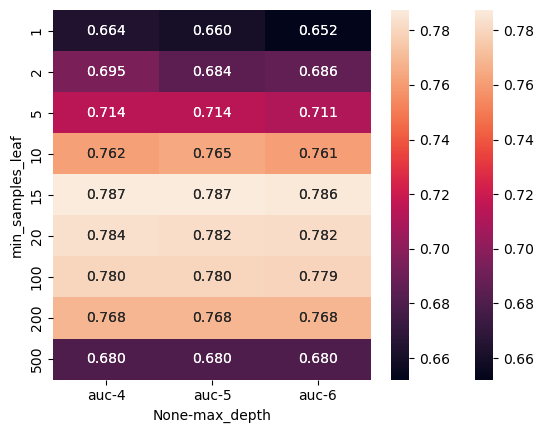

In [48]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")
plt.show()

In [49]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [53]:
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7744726453706618

In [54]:
scores = []
 
for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
 
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
     
    scores.append((n, auc))
 
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])
df_scores

,n_estimators,auc
0,10,0.774473
1,20,0.802239
2,30,0.811820
3,40,0.813912
4,50,0.815480
5,60,0.814872
6,70,0.816234
7,80,0.815081
8,90,0.815229
9,100,0.815665


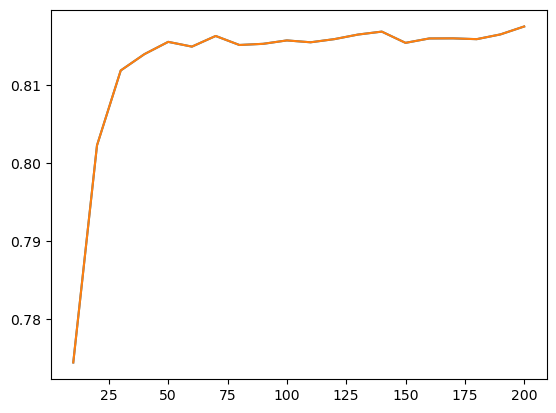

In [56]:
plt.plot(df_scores.n_estimators, df_scores.auc)
plt.show()

In [57]:
scores = []
 
for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)
 
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
 
        scores.append((d, n, auc))
 
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,max_depth,n_estimators,auc
0,5,10,0.787699
1,5,20,0.797731
2,5,30,0.800305
3,5,40,0.799708
4,5,50,0.799878


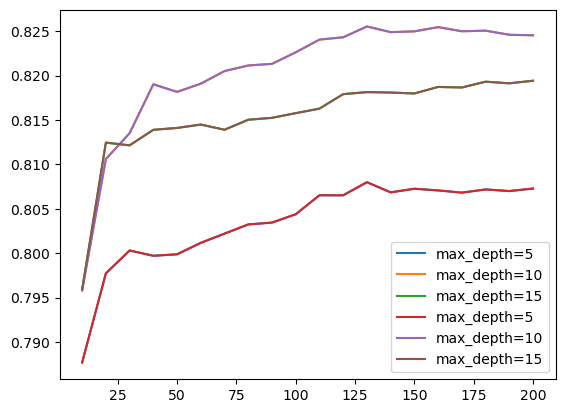

In [59]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
     
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)
 
plt.legend()
plt.show()

In [60]:
max_depth = 10

In [61]:
scores = []
 
for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)
 
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
 
        scores.append((s, n, auc))
 
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

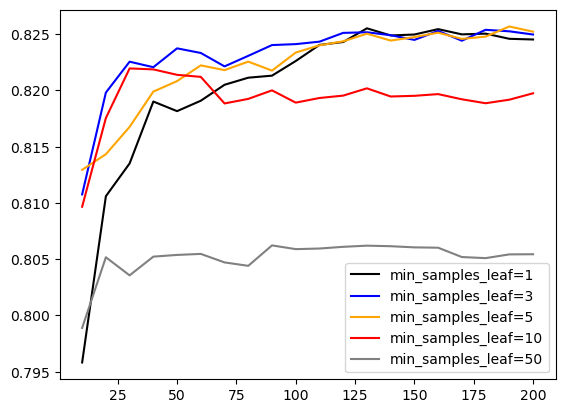

In [64]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
min_samples_leaf_values = [1, 3, 5, 10, 50]
 
for s, col in zip(min_samples_leaf_values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
     
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)
 
plt.legend()
plt.show()

In [65]:
min_samples_leaf = 3

In [66]:
rf = RandomForestClassifier(n_estimators=100,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1,
                            n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_jobs=-1,
                       random_state=1)

In [72]:
features = dv.get_feature_names_out().tolist()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [73]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
     
    'objective': 'binary:logistic',
    'nthread': 8,
     
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [74]:
y_pred = model.predict(dval)

In [75]:
roc_auc_score(y_val, y_pred)

0.8065256351262986

In [77]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [78]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
     
    'objective': 'binary:logistic',
 
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}
 
model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  evals=watchlist)

[0]	train-logloss:0.49703	val-logloss:0.54305
[1]	train-logloss:0.44463	val-logloss:0.51462
[2]	train-logloss:0.40707	val-logloss:0.49896
[3]	train-logloss:0.37760	val-logloss:0.48654
[4]	train-logloss:0.35990	val-logloss:0.48007
[5]	train-logloss:0.33931	val-logloss:0.47563
[6]	train-logloss:0.32586	val-logloss:0.47413
[7]	train-logloss:0.31409	val-logloss:0.47702
[8]	train-logloss:0.29962	val-logloss:0.48205
[9]	train-logloss:0.29216	val-logloss:0.47996
[10]	train-logloss:0.28407	val-logloss:0.47969
[11]	train-logloss:0.27583	val-logloss:0.47888
[12]	train-logloss:0.27127	val-logloss:0.47697
[13]	train-logloss:0.26525	val-logloss:0.47871
[14]	train-logloss:0.25734	val-logloss:0.48096
[15]	train-logloss:0.25186	val-logloss:0.48160
[16]	train-logloss:0.24849	val-logloss:0.47982
[17]	train-logloss:0.24144	val-logloss:0.48086
[18]	train-logloss:0.23796	val-logloss:0.47978
[19]	train-logloss:0.23390	val-logloss:0.47857
[20]	train-logloss:0.22833	val-logloss:0.48036
[21]	train-logloss:0.22

In [80]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
     
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
 
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}
 
model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

[0]	train-auc:0.86730	val-auc:0.77938
[5]	train-auc:0.93086	val-auc:0.80858
[10]	train-auc:0.95447	val-auc:0.80851
[15]	train-auc:0.96554	val-auc:0.81334
[20]	train-auc:0.97464	val-auc:0.81729
[25]	train-auc:0.97953	val-auc:0.81686
[30]	train-auc:0.98579	val-auc:0.81543
[35]	train-auc:0.99011	val-auc:0.81206
[40]	train-auc:0.99421	val-auc:0.80922
[45]	train-auc:0.99548	val-auc:0.80842
[50]	train-auc:0.99653	val-auc:0.80918
[55]	train-auc:0.99765	val-auc:0.81114
[60]	train-auc:0.99817	val-auc:0.81172
[65]	train-auc:0.99887	val-auc:0.80798
[70]	train-auc:0.99934	val-auc:0.80870
[75]	train-auc:0.99965	val-auc:0.80555
[80]	train-auc:0.99979	val-auc:0.80549
[85]	train-auc:0.99988	val-auc:0.80374
[90]	train-auc:0.99993	val-auc:0.80409
[95]	train-auc:0.99996	val-auc:0.80548
[100]	train-auc:0.99998	val-auc:0.80509
[105]	train-auc:0.99999	val-auc:0.80629
[110]	train-auc:1.00000	val-auc:0.80637
[115]	train-auc:1.00000	val-auc:0.80494
[120]	train-auc:1.00000	val-auc:0.80574
[125]	train-auc:1.0000

In [81]:
%%capture output
 
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
     
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
 
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}
 
model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [83]:
s = output.stdout
print(s)

[0]	train-auc:0.86730	val-auc:0.77938
[5]	train-auc:0.93086	val-auc:0.80858
[10]	train-auc:0.95447	val-auc:0.80851
[15]	train-auc:0.96554	val-auc:0.81334
[20]	train-auc:0.97464	val-auc:0.81729
[25]	train-auc:0.97953	val-auc:0.81686
[30]	train-auc:0.98579	val-auc:0.81543
[35]	train-auc:0.99011	val-auc:0.81206
[40]	train-auc:0.99421	val-auc:0.80922
[45]	train-auc:0.99548	val-auc:0.80842
[50]	train-auc:0.99653	val-auc:0.80918
[55]	train-auc:0.99765	val-auc:0.81114
[60]	train-auc:0.99817	val-auc:0.81172
[65]	train-auc:0.99887	val-auc:0.80798
[70]	train-auc:0.99934	val-auc:0.80870
[75]	train-auc:0.99965	val-auc:0.80555
[80]	train-auc:0.99979	val-auc:0.80549
[85]	train-auc:0.99988	val-auc:0.80374
[90]	train-auc:0.99993	val-auc:0.80409
[95]	train-auc:0.99996	val-auc:0.80548
[100]	train-auc:0.99998	val-auc:0.80509
[105]	train-auc:0.99999	val-auc:0.80629
[110]	train-auc:1.00000	val-auc:0.80637
[115]	train-auc:1.00000	val-auc:0.80494
[120]	train-auc:1.00000	val-auc:0.80574
[125]	train-auc:1.0000

In [84]:
def parse_xgb_output(output):
    results = []
 
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
 
        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])
 
        results.append((it, train, val))
     
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [85]:
df_score = parse_xgb_output(output)
df_score

,num_iter,train_auc,val_auc
0,0,0.86730,0.77938
1,5,0.93086,0.80858
2,10,0.95447,0.80851
3,15,0.96554,0.81334
4,20,0.97464,0.81729
5,25,0.97953,0.81686
6,30,0.98579,0.81543
7,35,0.99011,0.81206
8,40,0.99421,0.80922
9,45,0.99548,0.80842


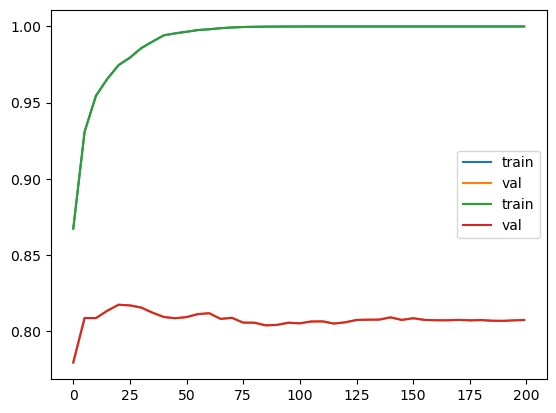

In [87]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()
plt.show()

In [91]:
scores = {}

In [92]:
%%capture output
 
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
     
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
     
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
}
 
model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                 verbose_eval=5,
                 evals=watchlist)

In [93]:
'eta=%s' % (xgb_params['eta'])

'eta=0.3'

In [94]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.3'

In [97]:
scores['eta=0.3']

,num_iter,train_auc,val_auc
0,0,0.86730,0.77938
1,5,0.93086,0.80858
2,10,0.95447,0.80851
3,15,0.96554,0.81334
4,20,0.97464,0.81729
5,25,0.97953,0.81686
6,30,0.98579,0.81543
7,35,0.99011,0.81206
8,40,0.99421,0.80922
9,45,0.99548,0.80842


In [98]:
%%capture output
 
xgb_params = {
    'eta': 1.0, 
    'max_depth': 6,
    'min_child_weight': 1,
     
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
 
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}
 
model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [99]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=1.0'

In [100]:
scores['eta=1.0']

,num_iter,train_auc,val_auc
0,0,0.86730,0.77938
1,5,0.95857,0.79136
2,10,0.98061,0.78355
3,15,0.99549,0.78050
4,20,0.99894,0.78591
5,25,0.99989,0.78401
6,30,1.00000,0.78371
7,35,1.00000,0.78234
8,40,1.00000,0.78184
9,45,1.00000,0.77963


In [101]:
%%capture output
 
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
     
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
 
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}
 
model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [102]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.1'

In [103]:
	
scores['eta=0.1']

,num_iter,train_auc,val_auc
0,0,0.86730,0.77938
1,5,0.90325,0.79290
2,10,0.91874,0.80510
3,15,0.93126,0.81380
4,20,0.93873,0.81804
5,25,0.94638,0.82065
6,30,0.95338,0.82063
7,35,0.95874,0.82404
8,40,0.96325,0.82644
9,45,0.96694,0.82602


In [104]:
%%capture output
 
xgb_params = {
    'eta': 0.05, 
    'max_depth': 6,
    'min_child_weight': 1,
     
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
 
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}
 
model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [105]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.05'

In [106]:
scores['eta=0.05']

,num_iter,train_auc,val_auc
0,0,0.86730,0.77938
1,5,0.88650,0.79584
2,10,0.90368,0.79623
3,15,0.91072,0.79938
4,20,0.91774,0.80510
5,25,0.92385,0.80895
6,30,0.92987,0.81175
7,35,0.93379,0.81480
8,40,0.93856,0.81547
9,45,0.94316,0.81807


In [107]:
%%capture output
 
xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
     
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
 
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}
 
model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [108]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.01'

In [109]:
scores['eta=0.01']

,num_iter,train_auc,val_auc
0,0,0.86730,0.77938
1,5,0.87157,0.77925
2,10,0.87247,0.78051
3,15,0.87541,0.78302
4,20,0.87584,0.78707
5,25,0.88406,0.79331
6,30,0.89027,0.79763
7,35,0.89559,0.79914
8,40,0.89782,0.79883
9,45,0.89983,0.79845


In [110]:
scores.keys()

dict_keys(['eta=0.3', 'eta=1.0', 'eta=0.1', 'eta=0.05', 'eta=0.01'])

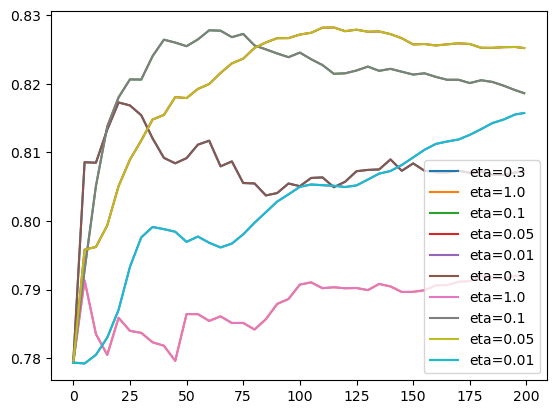

In [112]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)
plt.legend()
plt.show()

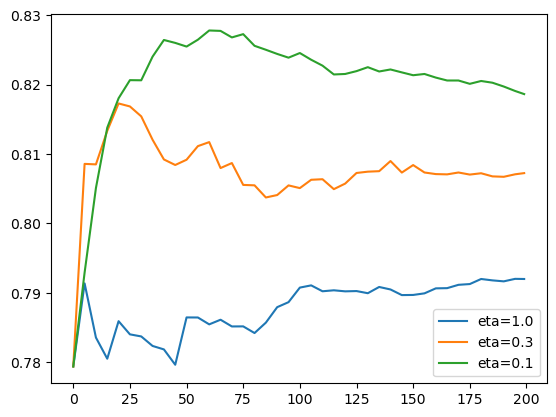

In [115]:
etas = ['eta=1.0', 'eta=0.3', 'eta=0.1']
for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)
plt.legend()
plt.show()

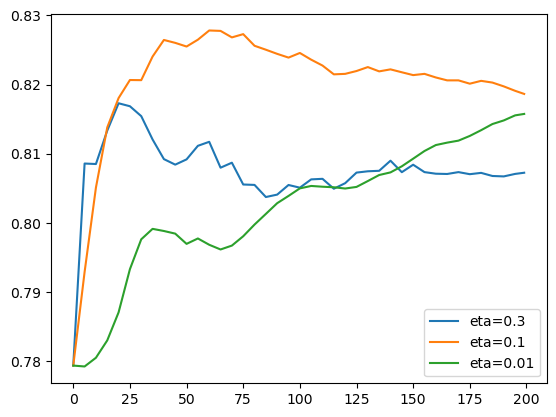

In [118]:
etas = ['eta=0.3', 'eta=0.1', 'eta=0.01']
for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)
plt.legend()
plt.show()

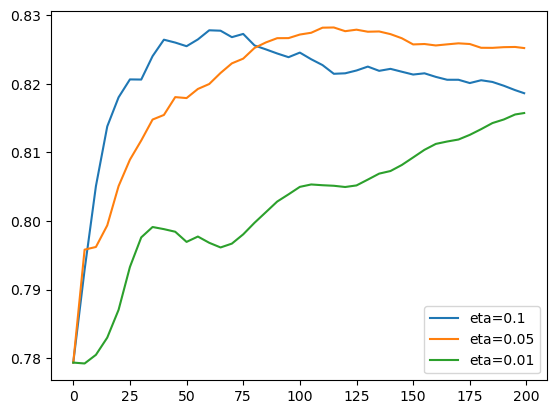

In [121]:
etas = ['eta=0.1', 'eta=0.05', 'eta=0.01']
for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)
plt.legend()
plt.show()

In [122]:
scores = {}

In [123]:
%%capture output
 
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
     
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
 
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}
 
model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

In [124]:
%%capture output
 
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,
     
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
 
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}
 
model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

In [125]:
%%capture output
 
xgb_params = {
    'eta': 0.1, 
    'max_depth': 4,
    'min_child_weight': 1,
     
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
 
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}
 
model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

In [126]:
%%capture output
 
xgb_params = {
    'eta': 0.1, 
    'max_depth': 10,
    'min_child_weight': 1,
     
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
 
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}
 
model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

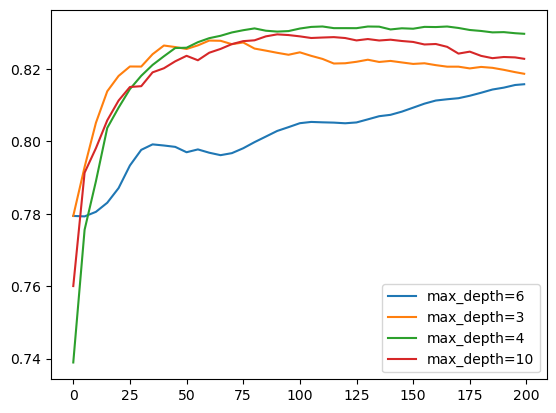

In [130]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)
 
plt.legend()
plt.show()

In [143]:
scores = {}

In [144]:
%%capture output
 
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,
     
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
 
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}
 
model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

In [145]:
%%capture output
 
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 10,
     
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
 
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}
 
model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

In [146]:
%%capture output
 
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 30,
     
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
 
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}
 
model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

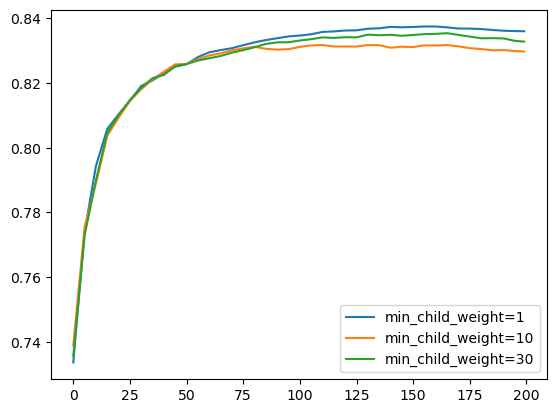

In [147]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)
 
plt.legend()
plt.show()

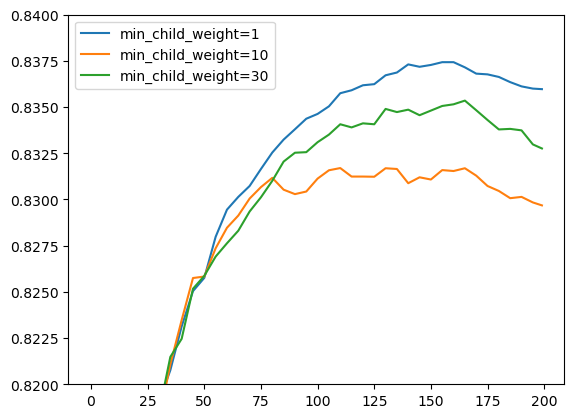

In [148]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)
 
plt.ylim(0.82, 0.84)
plt.legend()
plt.show()

In [149]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,
 
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
 
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}
 
model = xgb.train(xgb_params, dtrain, num_boost_round=175)

In [150]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [151]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=10,
                            min_samples_leaf=3,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

In [153]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,
 
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
 
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}
 
model = xgb.train(xgb_params, dtrain, num_boost_round=175)

In [154]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7850802838390931

In [155]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8249709379767989

In [156]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8309347073212081

In [157]:
df_full_train = df_full_train.reset_index(drop=True)

In [158]:
y_full_train = (df_full_train.status == 'default').astype(int).values
del df_full_train['status']
y_full_train

array([0, 1, 0, ..., 0, 0, 1])

In [159]:
dicts_full_train = df_full_train.to_dict(orient='records')
 
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)
 
dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [160]:
feature_names = list(dv.get_feature_names_out())
feature_names

['age',
 'amount',
 'assets',
 'debt',
 'expenses',
 'home=ignore',
 'home=other',
 'home=owner',
 'home=parents',
 'home=private',
 'home=rent',
 'home=unk',
 'income',
 'job=fixed',
 'job=freelance',
 'job=others',
 'job=partime',
 'job=unk',
 'marital=divorced',
 'marital=married',
 'marital=separated',
 'marital=single',
 'marital=unk',
 'marital=widow',
 'price',
 'records=no',
 'records=yes',
 'seniority',
 'time']

In [161]:
feature_names = list(dv.get_feature_names_out())
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=feature_names)
dtest = xgb.DMatrix(X_test, feature_names=feature_names)

In [162]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,
 
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
 
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}
 
model = xgb.train(xgb_params, dfulltrain, num_boost_round=175)

In [163]:
y_pred = model.predict(dtest)
roc_auc_score(y_test, y_pred)

0.8289367577342261